<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [129]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [130]:
from bs4 import BeautifulSoup
# import requests

df = pd.read_csv('data/job_listings.csv', index_col=0)

# Define a function to clean html tags
def clean_html(text):
    bytes = eval(text)
    soup = BeautifulSoup(bytes, 'html.parser')
    return soup.get_text()

# Remove '\n'
df['description'] = df['description'].apply(clean_html).replace(r'\n',' ', regex=True)

# Remove unicode
df['description'] = df['description'].apply(lambda x: x.encode('ascii', 'ignore').strip())

# Convert description from bytes to string
df['description'] = df['description'].str.decode("utf-8")
df.head()

,description,title
0,Job Requirements: Conceptual understanding in ...,Data scientist
1,"Job Description As a Data Scientist 1, you wi...",Data Scientist I
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist
4,Location: USA multiple locations 2+ years of ...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [131]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# The Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Make the tokens
tokens = []
for txt in tokenizer.pipe(df['description'], batch_size=500):
    txt_tokens = [token.text for token in txt]
    tokens.append(txt_tokens)
df['tokens'] = tokens
df['tokens'].head()

0    [Job, Requirements:, Conceptual, understanding...
1    [Job, Description,  , As, a, Data, Scientist, ...
2    [As, a, Data, Scientist, you, will, be, workin...
3    [$4,969, -, $6,756, a, monthContractUnder, the...
4    [Location:, USA,  , multiple, locations, 2+, y...
Name: tokens, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [132]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the transformer
vect = CountVectorizer(stop_words='english')

# Build vocab
vect.fit(df['description'])

# Transform text
dtm = vect.transform(df['description'])

# Sparse Matrix
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [133]:
# Get word counts for each listing
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,00,000,02115,03,0305,0356,04,062,06366,08,...,zf,zfs,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich,zurichs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [134]:
def count(data, n=None):
    """
    List the top n words in a vocabulary
    """
    vect = CountVectorizer(stop_words='english')
    vect.fit(data)
    dtm = vect.transform(data)
    sum_words = dtm.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

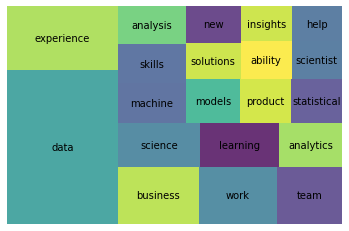

In [135]:
import squarify
import matplotlib.pyplot as plt

top20_words = pd.DataFrame(count(df['description'], n=20), columns=['word', 'count'])

squarify.plot(sizes=top20_words['count'], label=top20_words['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [136]:
import spacy
nlp = spacy.load("en_core_web_lg")

# Define tokenize function
def tokenize(text):
    txt = nlp(text)
    return [token.lemma_.strip() for token in txt if (token.is_stop != True) and (token.is_punct != True)]

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=0.003)

# Create a vocabulary and get word counts per listing
dtm = tfidf.fit_transform(df['description'])

# Get feature names to use a dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,00,000,03,04,06366,10,100,1001,105,1079302,...,york,youll,young,youre,youve,yrs,zero,zf,zfs,zogsports
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [138]:
from sklearn.neighbors import NearestNeighbors

# Fit on dtm
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [139]:
# Query Using kneighbors 
nn.kneighbors([dtm.iloc[0]])

(array([[0.        , 1.27537194, 1.2842154 , 1.31030399, 1.31431452]]),
 array([[  0, 276, 274, 115, 366]], dtype=int64))

In [140]:
df['description'][0]

"Job Requirements: Conceptual understanding in Machine Learning models like Naive Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role) Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R Ability to communicate Model findings to both Technical and Non-Technical stake holders Hands on experience in SQL/Hive or similar programming language Must show past work via GitHub, Kaggle or any other published article Master's degree in Statistics/Mathematics/Computer Science or any other quant specific field. Apply Now"

In [141]:
df['description'][276]

"Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities  we're just getting started. The Infrastructure Strategy group is responsible for the strategic analysis to support and enable the continued growth critical to Facebooks infrastructure organization. The ideal candidate will be passionate about Facebook, have strong analytical and modeling aptitude and has experience usi

In [142]:
ideal = ["""
Responsilibilites: working with different libraries to get insight from data; build machine learning models; data engineering; SQL and NoSQL databases
"""]

In [143]:
# Query the ideal job
new = tfidf.transform(ideal)
nn.kneighbors(new.todense())

(array([[1.27761071, 1.30840844, 1.32117472, 1.32207922, 1.32207922]]),
 array([[276, 151, 307, 233, 389]], dtype=int64))

In [144]:
# Inspect most relevant job
df['description'][276]

"Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities  we're just getting started. The Infrastructure Strategy group is responsible for the strategic analysis to support and enable the continued growth critical to Facebooks infrastructure organization. The ideal candidate will be passionate about Facebook, have strong analytical and modeling aptitude and has experience usi

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 